In [1]:
import os
import sys
import gensim
import numpy as np

ROOT = os.path.dirname(os.getcwd())
#path_data = os.path.join(ROOT, 'data')
path_data = 'C:\\Users\\Gosia\\Desktop\\'
sys.path.insert(0, ROOT)

In [2]:
from matchms.importing.load_from_msp import load_from_msp
spectrums = list(load_from_msp('C:\\Users\\Gosia\\Desktop\\MoNA-export-GC-MS_Spectra-msp\\MoNA-export-GC-MS_Spectra.msp'))


In [3]:
from matchms.filtering import normalize_intensities
from matchms.filtering import select_by_mz
from matchms.filtering import select_by_relative_intensity
from matchms.filtering import reduce_to_number_of_peaks
from matchms.filtering import require_minimum_number_of_peaks

def apply_my_filters(s):
    s = select_by_mz(s, mz_from=0, mz_to=1000)
    s = normalize_intensities(s)
    s = select_by_relative_intensity(s, intensity_from=0.05, intensity_to=1)
    return s

In [4]:
# apply filters to the data
spectrums_classical = [apply_my_filters(s) for s in spectrums]

# omit spectrums that didn't qualify for analysis
spectrums = [s for s in spectrums_classical if s is not None and 'inchikey' in s.metadata]

print("{} remaining spectra.".format(len(spectrums)))

18892 remaining spectra.


In [5]:
inchi_dict = {}
for s in spectrums:
    ik = s.metadata.get('inchikey','')
    init_ik = ik.split('-')[0]
    if not init_ik in inchi_dict:
        inchi_dict[init_ik] = [s]
    else:
        inchi_dict[init_ik].append(s)


In [6]:
query_size = 1000

In [7]:
# choosing queries from multis ensures a possible true match
multis = set([i for i,v in inchi_dict.items() if len(v) > 1])

matching_keys = np.random.choice(list(multis), size=query_size, replace=False)

query_spec = {}
spectrums_lib = []
# We select query_size queries that have at least 1 matching spectrum in the library
for q in matching_keys:
    spec_to_add = np.random.choice(inchi_dict[q], size=1, replace=False)
    query_spec[spec_to_add[0].metadata['inchikey']] = spec_to_add[0]

# And everything else goes into the library
for s in spectrums:
    if s.metadata['inchikey'] not in query_spec or s != query_spec[s.metadata['inchikey']]:
        spectrums_lib.append(s)

spectrums_query = list(query_spec.values())

In [8]:
print(len(spectrums_query), len(spectrums_lib))

1000 17892


In [47]:
c = {}
for specs_ in inchi_dict.values():
    c.setdefault(len(specs_),0)
    c[len(specs_)] += 1
for k in sorted(c):
    print(k,c[k])

1 5869
2 1695
3 338
4 410
5 143
6 232
7 72
8 128
9 43
10 70
11 29
12 29
13 11
14 18
15 8
16 15
17 5
18 7
19 1
20 5
21 1
22 2
23 2
24 1
25 1
26 1
30 1
31 1
39 1
44 1
49 1
50 1
76 1


In [9]:
from spec2vec import Spec2Vec
from spec2vec import SpectrumDocument

documents = [SpectrumDocument(s, n_decimals=0) for s in spectrums]


In [10]:
from spec2vec.model_building import train_new_word2vec_model

path_models = os.path.join(path_data, "trained_models")
model_file = os.path.join(path_models, "spec2vec_gcms_model_50.model")

iterations = [1, 3, 5, 10, 15, 20, 25, 30]

# Train model with default parameters
model = train_new_word2vec_model(documents, iterations, model_file, size=50)

The value of size is set from 300 (default) to 50
  Epoch 1 of 30.Change in loss after epoch 1: 141520.4375
Saving model with name: C:\Users\Gosia\Desktop\trained_models\spec2vec_gcms_model_50_iter_1.model
  Epoch 2 of 30.Change in loss after epoch 2: 132790.9375
  Epoch 3 of 30.Change in loss after epoch 3: 129153.8125
Saving model with name: C:\Users\Gosia\Desktop\trained_models\spec2vec_gcms_model_50_iter_3.model
  Epoch 4 of 30.Change in loss after epoch 4: 120176.5
  Epoch 5 of 30.Change in loss after epoch 5: 129326.75
Saving model with name: C:\Users\Gosia\Desktop\trained_models\spec2vec_gcms_model_50_iter_5.model
  Epoch 6 of 30.Change in loss after epoch 6: 119906.125
  Epoch 7 of 30.Change in loss after epoch 7: 109046.8125
  Epoch 8 of 30.Change in loss after epoch 8: 130149.625
  Epoch 9 of 30.Change in loss after epoch 9: 114309.0
  Epoch 10 of 30.Change in loss after epoch 10: 126971.0
Saving model with name: C:\Users\Gosia\Desktop\trained_models\spec2vec_gcms_model_50_it

Create spectrum "documents"

In [11]:
from rdkit.Chem import MolFromSmiles, MolToSmiles
from rdkit.Chem.inchi import MolFromInchi, MolToInchi
from rdkit.Chem.rdMolDescriptors import CalcExactMolWt, CalcMolFormula

def f(specs):
    successes = []
    for s in specs:
        try:
            mol = MolFromSmiles(s.get('smiles'))
        except Exception as e:
            pass
        if mol is not None:
            exact_mass_smi = CalcExactMolWt(mol)
            #print(mol,exact_mass_smi,s.get('parent_mass'))
            #if s.get('parent_mass') is None
            successes.append(s)
            s.set('very_exact_mass', exact_mass_smi)
    return successes

In [12]:
spectrums_query = f(spectrums_query)
spectrums_lib = f(spectrums_lib)

In [13]:
print(len(spectrums_query), len(spectrums_lib))

997 17854


In [14]:
from spec2vec import Spec2Vec
from spec2vec import SpectrumDocument

documents_query = [SpectrumDocument(s, n_decimals=0) for s in spectrums_query]
documents_lib = [SpectrumDocument(s, n_decimals=0) for s in spectrums_lib]
print(documents_query)

[<spec2vec.SpectrumDocument.SpectrumDocument object at 0x0000018B884C4190>, <spec2vec.SpectrumDocument.SpectrumDocument object at 0x0000018B884C4B80>, <spec2vec.SpectrumDocument.SpectrumDocument object at 0x0000018B884C4BE0>, <spec2vec.SpectrumDocument.SpectrumDocument object at 0x0000018B884C4C40>, <spec2vec.SpectrumDocument.SpectrumDocument object at 0x0000018B884C4C70>, <spec2vec.SpectrumDocument.SpectrumDocument object at 0x0000018B884C4CA0>, <spec2vec.SpectrumDocument.SpectrumDocument object at 0x0000018B884C4E80>, <spec2vec.SpectrumDocument.SpectrumDocument object at 0x0000018B884C4EB0>, <spec2vec.SpectrumDocument.SpectrumDocument object at 0x0000018B884C4F40>, <spec2vec.SpectrumDocument.SpectrumDocument object at 0x0000018B8847BCD0>, <spec2vec.SpectrumDocument.SpectrumDocument object at 0x0000018B884C4FA0>, <spec2vec.SpectrumDocument.SpectrumDocument object at 0x0000018B884C4F10>, <spec2vec.SpectrumDocument.SpectrumDocument object at 0x0000018B884C4DC0>, <spec2vec.SpectrumDocume

In [15]:
intensity_weighting_power = 0.5
allowed_missing_percentage = 15
from cosine_calc import get_hits

hits = get_hits( documents_query, documents_lib, metaKey='very_exact_mass', spec2vec_model=model, precursor_tol=1,
                                                        intensity_weighting_power=intensity_weighting_power,
                                                        allowed_missing_percentage=allowed_missing_percentage, passatutto=True)
len(hits)

997

In [16]:
# out of
print( len(documents_query) )
# we got this many hits
print( len( hits ))
# and out of those this many were false
print( len( [ h for h in hits if not h.hit ]))

997
997
312


In [17]:
# Calculating true q-value scores
from q_value_calc import calculate_q_value
q_list_true = calculate_q_value(hits)

In [43]:
from knockoffs import generate_knockoffs

diags = [3,4,10,15]

q_list_knockoffs = {}
for diag in diags:
        for comp in [2]:
                try:
                    knockoff_documents = generate_knockoffs(model,documents_lib,allowed_missing_percentage=allowed_missing_percentage,n_components=comp, diagonal_matrix=diag)

                    hits_knockoffs = get_hits(documents_query, knockoff_documents, decoys=True, spec2vec_model=model, precursor_tol=3, metaKey="very_exact_mass",
                                                                            intensity_weighting_power=intensity_weighting_power,
                                                                            allowed_missing_percentage=allowed_missing_percentage, passatutto=False)
                    q_list_knockoffs[(diag, comp)] = calculate_q_value(hits+hits_knockoffs,True)
                except Exception as e:
                    print( diag, "failed", e )
                    #raise

Embedding vector size: 50
Embedding vector size: 50
Embedding vector size: 50
Embedding vector size: 50


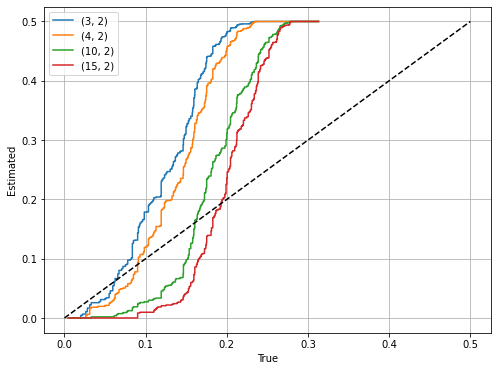

In [44]:
# plot estimated and true q-values
def combine_true_est(q_val_true,q_val_est):
    res = []
    q_idx = 0
    for q_e, _, score in q_val_est:
        while q_idx < len(q_val_true)-1 and q_val_true[q_idx+1][2] >= score:
            q_idx += 1
        res.append((score, q_val_true[q_idx][0], q_e))
    return res
        
to_plot = {}
for k,v in q_list_knockoffs.items():
    to_plot[k] = list(zip(*combine_true_est(q_list_true, v)))[1], list(zip(*combine_true_est(q_list_true, v)))[2]

import plot_q_vals
plot_q_vals.plot_q_vals( to_plot )